# 3-3 AICを使って変数選択しよう！
赤池情報量規準（Akaike's Information Criterion; AIC）は、元統計数理研究所所長の赤池弘次先生が考案した統計モデルの良さを評価するための指標です。小さいほど良いといえます。

scikit-learnにはAICを計算する関数はないので、自前で計算します。計算式は以下の通りです。

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
boston = load_boston()
X = pd.DataFrame(boston.data, columns= boston.feature_names)
y = boston.target

[`AIC = -2 * log(L) + 2 * k`]

ただし、Lは最大尤度、kは「説明変数と定数項」の数です。


誤差が正規分布に従うとすると、次の式に置き換えられる。

[`AIC = n * (log(2 * π * MSE) + 1) + 2 * k`]
ただし、nはデータ数、MSEは平均二乗誤差です。

In [2]:
# AICの計算
def AIC(model, X, y):
    from sklearn.metrics import mean_squared_error
    from math import log, pi
    n = len(y)
    mse = mean_squared_error(y, model.predict(X))
    k = model.coef_.shape[0] + int(model.fit_intercept)
    d = max(1e-308, 2 * pi * mse)
    return n * (log(d) + 1 ) + 2 *k

In [3]:
# サンプルでAICの計算
lr1 = LinearRegression().fit(X, y)
aic1 = AIC(lr1, X, y)
aic1

3025.6767200074596

In [4]:
# ダミーデータでAICの計算
X2, y2 = [[2, -1, 3], [-1, 2, -2]], [1, 0]
lr2 = LinearRegression().fit(X2, y2)
aic2 = AIC(lr2, X2, y2)
aic2

-134.6577425070096

# ステップワイズ法

AICを使った変数選択の方法として、ステップワイズ法を学習します。

ステップワイズ法は、以下の種類があります。

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from functools import lru_cache

ここで紹介するステップワイズ法では、AICを評価規準にします（他の評価規準を使う方法もあります）。
また、評価値の計算では、クロスバリデーションの平均値を使います。
同じ説明変数の組合せ（sel）に対し、calc_aic(sel)を実行するので、lru_cacheを指定してキャッシュします。

In [7]:
# ステップワイズ法のサブルーチン
def _calc_best(calc_aic, best, N, is_add):
    found, cur = False, best
    for i in range(N):
        key = (best[1] | {i}) if is_add else (best[1] - {i})
        v = calc_aic(tuple(key))
        if v < cur[0]:
            cur = v, key
    if cur[0] < best[0]:
        found, best = True, cur
    return found, best

ステップワイズ法（変数増減法）の手順

・ステップ 1. 説明変数候補を空にします。

・ステップ 2. 説明変数候補に新たな説明変数を1つ追加したとき、最も評価値（AIC）が良いものがあれば、追加します。

・ステップ 3. 説明変数候補から説明変数を1つ削除したとき、最も評価値（AIC）が良いものがあれば、削除します。

・ステップ 4. 削除が可能な間、ステップ3を繰り返します。

・ステップ 5. 更新がないか、全ての説明変数を選んだ場合は終了します。そうでない場合、ステップ2へ行きます。

関数_calc_bestは、ステップワイズ法のサブルーチンで、上記ステップの2と3に対応します。頭に「_」をつけた名前にして、非公開であることを表しています。

In [8]:
# ステップワイズ法
def stepwise(X, y, fit_intercept=True, cv=None):
    @lru_cache(maxsize=1024)
    def calc_aic(sel):
        X_ = X[:, sel]
        return cross_val_score(model.fit(X_, y), X_, y,
                               scoring=AIC, cv=cv).mean()
    model = LinearRegression(fit_intercept)
    N = X.shape[1]  # 説明変数数
    best = 1e308, set()  # 最良のAICと選択
    found = True
    while found and len(best[1]) < N:
        found, best = _calc_best(calc_aic, best, N, True)
        found2 = True
        while found2 and len(best[1]) > 1:
            found2, best = _calc_best(calc_aic, best, N, False)
            found |= found2
    return best[0], list(best[1])

関数stepwiseが、ステップワイズ法に対応します。引数は以下の通りです。

X：全ての説明変数（numpy.ndarray）

y：目的変数

fit_intercept：y切片の有無（LinearRegressionの引数）

cv：クロスバリデーションの分割数（cross_val_scoreの引数）

In [9]:
# ボストン市住宅価格データで変数選択
aic, sel = stepwise(X.values, y, cv=6)
aic, sel

(517.113545860427, [5, 10, 11, 12])

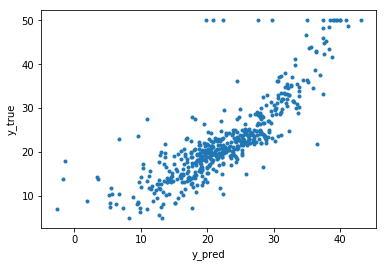

In [10]:
# 真値と予測値の散布図
X_sel = X.iloc[:, sel]
lr = LinearRegression().fit(X_sel, y)
y_pred = lr.predict(X_sel)
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.plot(y_pred, y, '.');

In [11]:
# 選択された説明変数の列名
X_sel.columns


Index(['RM', 'PTRATIO', 'B', 'LSTAT'], dtype='object')

aic, sel = stepwise(X.values, y, cv=6)で、ボストン市住宅価格データに対し、ステップワイズ法を実行しています。

散布図で見ると、良い結果になっていることが確認できます。
X_sel.columnsで、選択された説明変数の列名がわかります。PTRATIO, B, LSTAT, RMの4つが選ばれていることがわかります。